Here I test if extrapolating the mangling function even further has any effect on the obtained values

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import piscola as pisco
import numpy as np

import pickle
with open('rcparams.pickle', 'rb') as file:
    rcparams = pickle.load(file)
    plt.rcParams.update(rcparams)

In [8]:
def band_efficiency_lost(sn, bands, z_range, percent, units='mag'):
    
    f_ratio = {band:[] for band in bands}
    sed_info = sn.sed['info'][sn.sed['info'].phase==0.0]

    for band in bands:
        band_info = sn.filters[band]
        wave, trans = band_info['wave'], band_info['transmission']
        min_index, max_index = pisco.filter_effective_range(trans, percent)
        trim_wave, trim_trans = wave[min_index:max_index], trans[min_index:max_index]

        for z in z_range:
            sed_wave, sed_flux = sed_info.wave.values*(1+z), sed_info.flux.values/(1+z)
            #sed_wave, sed_flux = sed_info.wave.values*(1+z), np.ones_like(sed_info.wave.values)*1e3/(1+z)
            f_total = pisco.run_filter(sed_wave, sed_flux, wave, trans)
            f_partial = pisco.run_filter(sed_wave, sed_flux, trim_wave, trim_trans)
            f_ratio[band].append(f_partial/f_total)
            
        gain = wave.max() - trim_wave.max()
        print(f'Gain in {band}: {gain:.0f} Angstroms on both sides')

    for band in bands:
        f_ratio[band] = np.asarray(f_ratio[band])
        
    # for visualization
    bessell_bands = ['Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I']
    bessell_mean = [np.average(sn.filters[band]['wave']*sn.filters[band]['transmission'])/np.average(sn.filters[band]['transmission']) 
                                        for band in bessell_bands]
    bessell_diffs = np.diff(np.asarray(bessell_mean))
    wave_cuts = np.asarray([sn.filters[band]['wave'].mean() + bessell_diffs[i]/2 for i, band in enumerate(bessell_bands[:-1])])
    # add edges
    wave_cuts = np.r_[sn.filters['Bessell_U']['wave'].mean() - bessell_diffs[0]/2, 
                      wave_cuts, 
                      sn.filters['Bessell_I']['wave'].max() + bessell_diffs[-1]/2
                     ]
    # bands mean weighted wavelength
    bands_mean = [np.average(sn.filters[band]['wave']*sn.filters[band]['transmission'])/np.average(sn.filters[band]['transmission']) 
                                        for band in bands]
    z_cuts = {band:[band_mean/wave_cut - 1 for wave_cut in wave_cuts] for band, band_mean in zip(bands, bands_mean)}
        
    colors = ['k', 'b', 'g', 'r', 'y']
    
    for band in bands[0:]:

        fig, ax = plt.subplots(figsize=(7, 5))
        
        if units=='flux':
            ax.plot(z_range, f_ratio[band], label=f'Area={percent}%')
            ax.set_ylabel(r'flux$_{\rm Partial}$/flux$_{\rm Total}$ (%s)', fontsize=18)
        elif units=='mag':
            ax.plot(z_range, -2.5*np.log10(f_ratio[band]), label=f'Area={percent}%')
            ax.set_ylabel(r'm$_{\rm Partial}$ - m$_{\rm Total}$ [mag]', fontsize=18)

        for i, _ in enumerate(z_cuts[band][:-1]):
            z_left, z_right = z_cuts[band][i], z_cuts[band][i+1]
            
            if ((0 < z_left) and (z_left < z_range.max())) or ((0 < z_right) and (z_right < z_range.max())):
                ax.axvspan(z_left, z_right, label=bessell_bands[i], alpha=0.3, color=colors[i])     
            
        ax.set_title(band, fontsize=20)
        ax.set_xlabel('$z$', fontsize=18)
        ax.legend(fontsize=14)
        plt.xlim(0, z_range.max())
        plt.show()

Gain in Megacam_g: 135 Angstroms on both sides
Gain in Megacam_r: 170 Angstroms on both sides
Gain in Megacam_i: 259 Angstroms on both sides
Gain in Megacam_z: 46 Angstroms on both sides


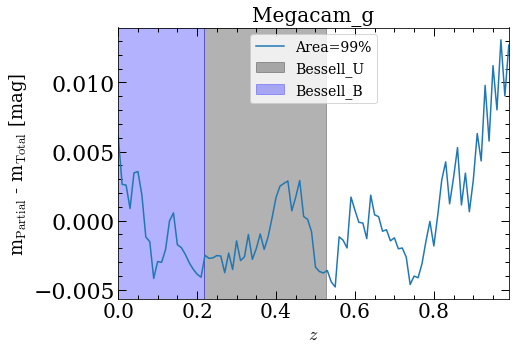

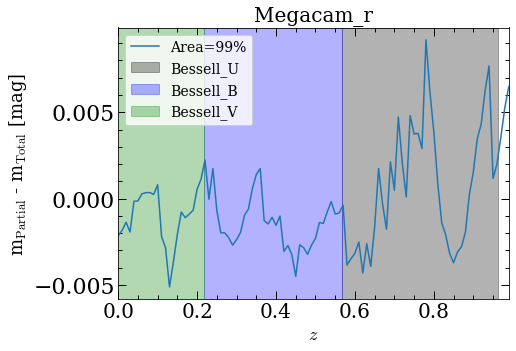

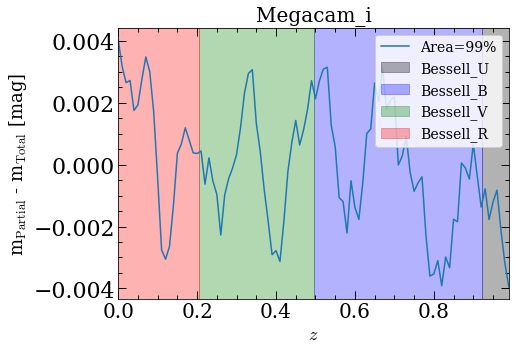

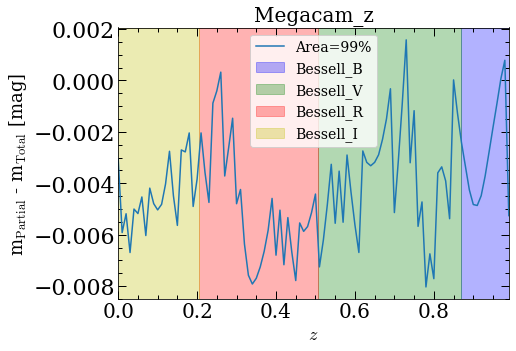

In [9]:
sn = pisco.sn_file('04D3ny', directory='data_jla/')
#sn = pisco.sn_file('SDSS13354', directory='data_jla/')
#bands = ['Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I']
bands = sn.bands
z_range = np.arange(0, 1., 0.01)
percent = 99

band_efficiency_lost(sn, bands, z_range, percent)